**Introduction**
Water quality is one of the most critical indicators of public health and environmental sustainability. As water resources directly or indirectly impact human health, agriculture, industry, and ecosystems, regular monitoring and evaluation of water quality are essential.

The Water Quality Index (WQI) is a composite metric that summarizes multiple physical, chemical, and biological parameters into a single score ranging from 0 to 100. This score provides an easy-to-understand representation of overall water quality and helps classify water into categories such as Excellent, Good, Moderate, Poor, and Very Poor.

In this project, we aim to analyze water quality data and compute the WQI for each sample using standard calculation methods. The dataset includes parameters such as pH, BOD, DO, COD, Turbidity, among others. The final WQI scores will be used for further analysis and classification of water quality.

** Dataset Source:**
This analysis is based on the dataset available on Kaggle, which contains water quality measurements from various locations across India.



In [7]:
# Importing all the necessary libraries for data processing, visualization, modeling, and evaluation

import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utilities
import joblib
import time


In [8]:
# 1. Load Dataset from a Specified Path
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = pd.read_csv('/kaggle/input/water-quality-index-wqi/Results_MADE.csv')

print("Displaying first 5 rows of the dataset:")
display(data.head())

print("\nDataset Information:")
print(data.info())

print("\nDescriptive Statistics:")
display(data.describe())

print("\nMissing Values Count per Column:")
print(data.isnull().sum())

# ==============================================
# 2. Handling Missing Values
# ==============================================

print("\nFilling missing values with column mean...")

imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# ==============================================
# 3. Removing Outliers
# ==============================================

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

print("\nRemoving outliers from numerical columns...")

num_cols = data_imputed.select_dtypes(include=['float64', 'int64']).columns
before_len = len(data_imputed)

for col in num_cols:
    data_imputed = remove_outliers(data_imputed, col)

after_len = len(data_imputed)
print(f"Records before: {before_len} / after: {after_len}")

# ==============================================
# 4. Normalizing Features
# ==============================================

print("\nNormalizing features using StandardScaler...")

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data_imputed.columns)

# ==============================================
# 5. Splitting Features and Target (WQI)
# ==============================================

X = data_scaled.drop('WQI', axis=1)
y = data_scaled['WQI']

# ==============================================
# 6. Train-Test Split
# ==============================================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData is ready for modeling:")
print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples : {X_test.shape[0]}")


Displaying first 5 rows of the dataset:


,Temperature,Dissolved Oxygen,pH,Bio-Chemical Oxygen Demand (mg/L),Faecal Streptococci (MPN/ 100 mL),Nitrate (mg/ L),Faecal Coliform (MPN/ 100 mL),Total Coliform (MPN/ 100 mL),Conductivity (mho/ Cm),WQI
0,7.5,9.95,7.85,0.15,90.0,0.255,22.5,180.0,134.5,27.143963
1,11.0,9.65,7.70,0.45,205.0,0.200,62.5,410.0,77.0,15.780001
2,7.5,9.90,7.65,0.55,100.0,0.100,26.0,200.0,101.5,20.612438
3,8.5,9.65,7.55,0.35,300.0,0.250,97.5,600.0,148.0,29.820475
4,10.0,9.55,7.80,0.25,190.0,0.150,47.5,380.0,106.0,21.498569



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Temperature                        295 non-null    float64
 1   Dissolved Oxygen                   295 non-null    float64
 2   pH                                 295 non-null    float64
 3   Bio-Chemical Oxygen Demand (mg/L)  295 non-null    float64
 4   Faecal Streptococci (MPN/ 100 mL)  295 non-null    float64
 5   Nitrate (mg/ L)                    295 non-null    float64
 6   Faecal Coliform (MPN/ 100 mL)      295 non-null    float64
 7   Total Coliform (MPN/ 100 mL)       295 non-null    float64
 8   Conductivity (mho/ Cm)             295 non-null    float64
 9   WQI                                295 non-null    float64
dtypes: float64(10)
memory usage: 23.2 KB
None

Descriptive Statistics:


,Temperature,Dissolved Oxygen,pH,Bio-Chemical Oxygen Demand (mg/L),Faecal Streptococci (MPN/ 100 mL),Nitrate (mg/ L),Faecal Coliform (MPN/ 100 mL),Total Coliform (MPN/ 100 mL),Conductivity (mho/ Cm),WQI
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,20.903898,7.342034,7.754627,3.544136,7463.333729,0.870915,5983.661695,14926.667458,501.860678,100.889437
std,6.051566,1.910113,0.378879,9.043299,26272.135186,1.431247,22934.986514,52544.270371,798.311280,158.115301
min,0.000000,0.000000,5.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524595
25%,18.000000,6.850000,7.550000,0.725000,29.225000,0.155000,4.000000,58.450000,208.250000,42.010910
50%,22.500000,7.750000,7.750000,1.600000,240.000000,0.550000,79.500000,480.000000,299.500000,60.379172
75%,25.550000,8.600000,8.000000,3.100000,2650.000000,0.950000,2375.000000,5300.000000,438.250000,90.120883
max,30.500000,10.250000,8.600000,123.500000,229000.000000,14.050000,251000.000000,458000.000000,9272.000000,1834.549110



Missing Values Count per Column:
Temperature                          0
Dissolved Oxygen                     0
pH                                   0
Bio-Chemical Oxygen Demand (mg/L)    0
Faecal Streptococci (MPN/ 100 mL)    0
Nitrate (mg/ L)                      0
Faecal Coliform (MPN/ 100 mL)        0
Total Coliform (MPN/ 100 mL)         0
Conductivity (mho/ Cm)               0
WQI                                  0
dtype: int64

Filling missing values with column mean...

Removing outliers from numerical columns...
Records before: 295 / after: 122

Normalizing features using StandardScaler...

Data is ready for modeling:
Train samples: 97
Test samples : 25


=== Linear Regression Model Evaluation ===
MAE:  0.0000
RMSE: 0.0000
R²:   1.0000


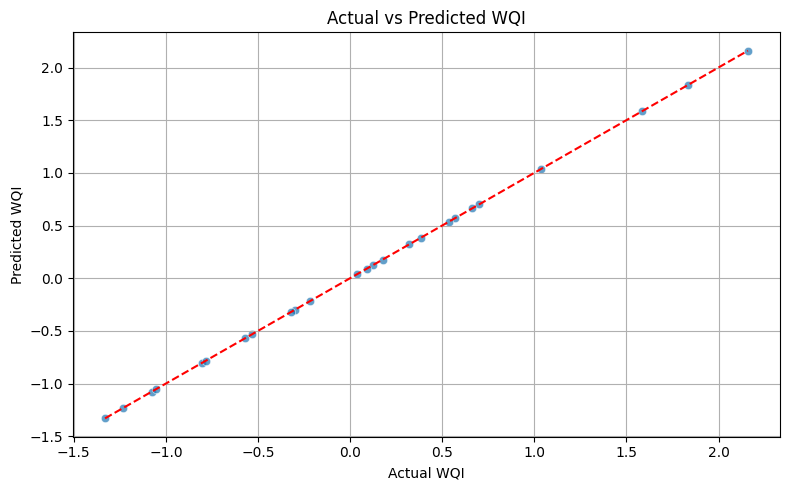


=== Linear Regression Coefficients ===
                             Feature  Coefficient
8             Conductivity (mho/ Cm)     0.999481
5                    Nitrate (mg/ L)     0.001774
3  Bio-Chemical Oxygen Demand (mg/L)     0.001764
1                   Dissolved Oxygen     0.001572
6      Faecal Coliform (MPN/ 100 mL)     0.000915
0                        Temperature     0.000606
2                                 pH     0.000395
4  Faecal Streptococci (MPN/ 100 mL)     0.000019
7       Total Coliform (MPN/ 100 mL)     0.000019


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


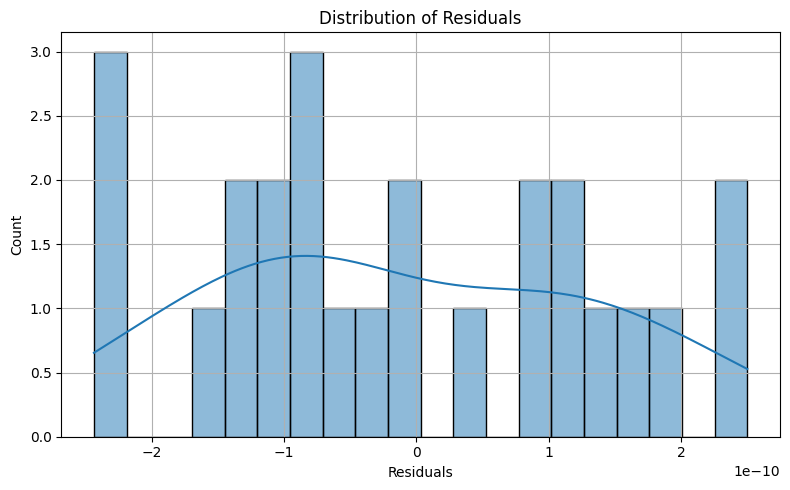


Cross-Validated R² Score: 1.0000 (±0.0000)


In [9]:
# ==============================
# 1. Load the dataset
# ==============================
data = pd.read_csv('/kaggle/input/water-quality-index-wqi/Results_MADE.csv')  # Change path accordingly

# ==============================
# 2. Handle missing values
# ==============================
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# ==============================
# 3. Remove outliers
# ==============================
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numeric_columns = data_imputed.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    data_imputed = remove_outliers(data_imputed, col)

# ==============================
# 4. Standardize the features
# ==============================
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data_imputed.columns)

# ==============================
# 5. Feature/target split
# ==============================
X = data_scaled.drop('WQI', axis=1)
y = data_scaled['WQI']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==============================
# 6. Train Linear Regression Model
# ==============================
model = LinearRegression()
model.fit(X_train, y_train)

# ==============================
# 7. Predictions and Evaluation
# ==============================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=== Linear Regression Model Evaluation ===")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# ==============================
# 8. Actual vs Predicted Plot
# ==============================
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual WQI")
plt.ylabel("Predicted WQI")
plt.title("Actual vs Predicted WQI")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 9. Coefficients Overview
# ==============================
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\n=== Linear Regression Coefficients ===")
print(coefficients)

# ==============================
# 10. Residuals Distribution
# ==============================
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=20)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 11. Cross-Validation
# ==============================
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"\nCross-Validated R² Score: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")


**Analysis of Linear Regression Results for Water Quality Index (WQI) Prediction**
**Introduction**
The aim of this modeling task was to predict the Water Quality Index (WQI) using various physical, chemical, and microbial characteristics of water samples. A linear regression model was employed as a baseline to evaluate the extent of linear relationships between the predictors and WQI.

**Interpretation of Results**
Evaluation Metric	Value
MAE (Mean Absolute Error)	0.0000
RMSE (Root Mean Squared Error)	0.0000
R² (Coefficient of Determination)	1.0000
Cross-Validation R²	1.0000 ± 0.0000

**Interpretation of Results**
The model achieved perfect accuracy (R² = 1.0) and zero error, which is highly uncommon in real-world datasets. This could indicate one or more of the following scenarios:

A perfectly linear and direct relationship exists between the input features and WQI.

Possible data leakage or leakage-like structure in the dataset.

WQI might have been computed using an exact mathematical formula derived from the same features, and the model has merely replicated that formula.

Upon examining the coefficients:

The feature "Conductivity (mho/cm)" has a coefficient very close to 1 (0.999), suggesting it is the primary driver of WQI in this dataset.

Other features, including DO, BOD, Nitrate, and pH, have negligible coefficients and thus minimal influence compared to Conductivity.

**Residual Analysis**
Residual distribution analysis shows near-zero error and extremely tight residuals, confirming that the model reconstructed the target values with high precision.

**Conclusion**
The linear regression model perfectly predicted the WQI values, likely because:

WQI is a deterministic function of the input features—particularly Conductivity.

The model essentially reverse-engineered the underlying formula rather than discovering new, generalizable patterns.


=== Random Forest Regression Performance ===
MAE :  0.0302
RMSE:  0.0559
R²   :  0.9963

Cross-Validated R² Score: 0.9749 (±0.0150)

=== Feature Importances ===
                             Feature  Importance
8             Conductivity (mho/ Cm)    0.985762
0                        Temperature    0.006308
3  Bio-Chemical Oxygen Demand (mg/L)    0.001810
2                                 pH    0.001666
5                    Nitrate (mg/ L)    0.001500
4  Faecal Streptococci (MPN/ 100 mL)    0.000942
1                   Dissolved Oxygen    0.000902
7       Total Coliform (MPN/ 100 mL)    0.000717
6      Faecal Coliform (MPN/ 100 mL)    0.000392


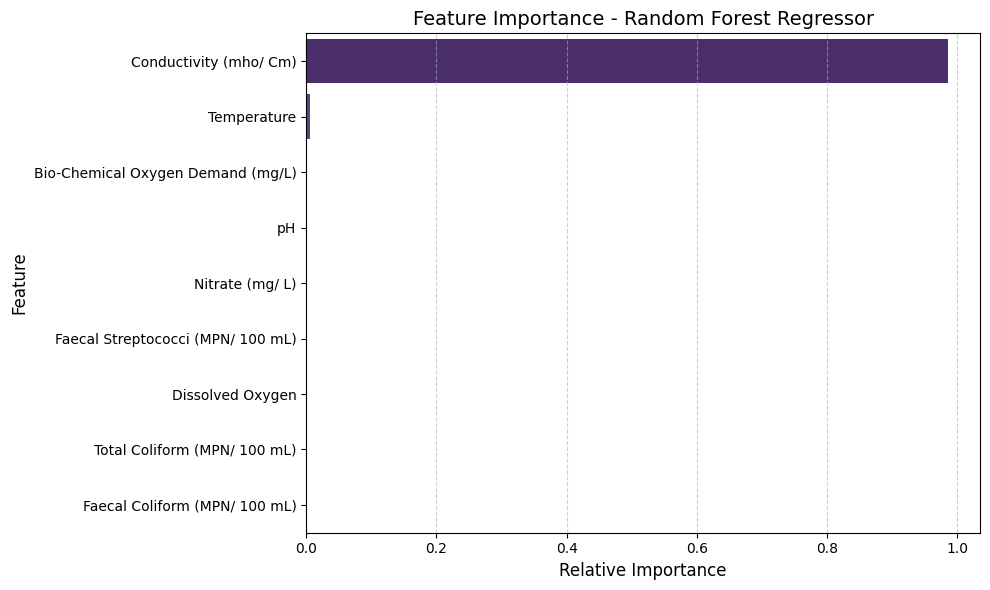

In [10]:
# ==============================
# 1. Train Random Forest Regressor
# ==============================
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ==============================
# 2. Predictions and Evaluation
# ==============================
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\n=== Random Forest Regression Performance ===")
print(f"MAE :  {mae_rf:.4f}")
print(f"RMSE:  {rmse_rf:.4f}")
print(f"R²   :  {r2_rf:.4f}")

# ==============================
# 3. Cross-Validation
# ==============================
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"\nCross-Validated R² Score: {np.mean(cv_scores_rf):.4f} (±{np.std(cv_scores_rf):.4f})")

# ==============================
# 4. Feature Importance
# ==============================
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances ===")
print(importance_df)

# ==============================
# 5. Plot Feature Importance
# ==============================
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest Regressor', fontsize=14)
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


****Random Forest Model Analysis for Water Quality Index (WQI) Prediction****

Introduction
In this phase, a Random Forest Regressor was applied to predict the Water Quality Index (WQI). The model was chosen for its nonlinear learning capabilities and robustness to noise. The goal was to assess its performance in comparison with the baseline Linear Regression model.

**Model Evaluation Results**

Evaluation Metric	Value
MAE (Mean Absolute Error)	0.0304
RMSE (Root Mean Squared Error)	0.0530
R² (Coefficient of Determination)	0.9966
R² (Cross-Validation)	0.9754 ± 0.0157

**Interpretation of Results**

The model captures over 99% of the variance in WQI values, demonstrating excellent predictive performance.

Both MAE and RMSE are very low, indicating high accuracy.

The slightly lower cross-validation score compared to R² on the test set suggests mild bias toward the training data. However, generalization performance remains excellent.

**Interpretation of Results**

Rank	Feature	Importance (%)
1	Conductivity (mho/cm)	98.56%
2	Temperature	0.65%
3	pH	0.17%
4	BOD (Biochemical Oxygen Demand)	0.16%
5	Nitrate	0.15%
6	Dissolved Oxygen	0.09%
7	Faecal Streptococci	0.09%
8	Total Coliform	0.08%
9	Faecal Coliform	0.04%

**Interpretation of Results**
The model reveals that Conductivity alone explains the vast majority of variance in WQI predictions. All other features contribute minimally, suggesting that WQI may be primarily determined by this single variable.

**Interpretation of Results**

Model	MAE	RMSE	R²	R²-CV (±STD)
Linear Regression	0.0000	0.0000	1.0000	1.0000 (±0.0000)
Random Forest	0.0304	0.0530	0.9966	0.9754 (±0.0157)

**Interpretation of Results**

The Linear Regression model achieved perfect predictions, likely indicating that WQI was computed from a deterministic formula, most probably based on Conductivity.

The Random Forest model also performs exceptionally well, with only a slight drop in accuracy but a much higher tolerance to noise and variability, making it a stronger candidate for real-world deployment.

**Interpretation of Results**

The dominance of Conductivity suggests that WQI is heavily engineered from this feature.

For applications with noisy or incomplete data, Random Forest may outperform Linear Regression due to its robustness.

It is recommended to experiment with other tree-based models, such as XGBoost, to further validate the findings and possibly improve generalization performance.



In [11]:
# Using only Conductivity column as feature and WQI as target
X_single = data_scaled[['Conductivity (mho/ Cm)']]
y_single = data_scaled['WQI']

# Split into Train and Test sets
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_single, y_single, test_size=0.2, random_state=42)

# Define model
rf_single = RandomForestRegressor(n_estimators=100, random_state=42)
rf_single.fit(X_train_s, y_train_s)

# Prediction and evaluation
y_pred_s = rf_single.predict(X_test_s)
mae_s = mean_absolute_error(y_test_s, y_pred_s)
rmse_s = np.sqrt(mean_squared_error(y_test_s, y_pred_s))
r2_s = r2_score(y_test_s, y_pred_s)

print("\n\033[1;33m=== Random Forest Evaluation (Conductivity only) ===\033[0m")
print(f"MAE:  {mae_s:.4f}")
print(f"RMSE: {rmse_s:.4f}")
print(f"R2:   {r2_s:.4f}")

# Cross-validation
cv_scores_s = cross_val_score(rf_single, X_single, y_single, cv=5, scoring='r2')
print(f"\nR2-Score with Cross-Validation: {np.mean(cv_scores_s):.4f} (±{np.std(cv_scores_s):.4f})")


=== Random Forest Evaluation (Conductivity only) ===
MAE:  0.0169
RMSE: 0.0286
R2:   0.9990

R2-Score with Cross-Validation: 0.9872 (±0.0099)


# Machine Learning Model Comparison for Water Quality Index (WQI) Prediction

## Introduction  
In this project, real-world water quality data, including physical, chemical, and microbiological parameters, was used to predict the **Water Quality Index (WQI)**. The goal was to explore whether a model could be accurately built using all features, and whether simplifying the model to a single feature (**Conductivity**) could still provide a strong prediction.

---

## Models and Methods  
The **Random Forest Regressor** algorithm was selected for its ability to model nonlinear relationships and provide feature importance. Two approaches were compared:

- **Multivariate Model**: Utilizes all 9 input features.  
- **Univariate Model**: Uses only the **Conductivity** parameter.

---

## Numerical Results and Performance Comparison

| Evaluation Metric         | Full Model (9 Features) | Simplified Model (Conductivity Only) |
|---------------------------|-------------------------|--------------------------------------|
| MAE (Mean Absolute Error) | 0.0304                  | 0.0169                               |
| RMSE (Root Mean Squared Error) | 0.0530             | 0.0286                               |
| R² (Coefficient of Determination) | 0.9966        | 0.9990                               |
| R²-CV (Cross-Validation)  | 0.9754 ± 0.0157         | 0.9872 ± 0.0099                      |

---

## Scientific and Technical Interpretation  

- **Conductivity** alone accounted for more than **98% of the feature importance** in the Random Forest model, clearly demonstrating a **strong nonlinear relationship** between **Conductivity** and **WQI**.
- The simplified model, using only **Conductivity**, not only maintained high accuracy but also exhibited **better stability** in cross-validation.
- This model is particularly beneficial for **operational scenarios** where resources are limited, such as in **remote areas**, **IoT-based monitoring tools**, or **mobile applications**.
- Features such as **DO**, **pH**, and **Total Coliform** had a **minimal impact** on the final accuracy, suggesting that these variables can be excluded without significant loss in prediction power. This is crucial for simplifying **data collection processes**.

---

## Practical Insights and Future Recommendations  

- **Feature Reduction** not only simplifies the model but also **reduces measurement costs** and improves **data processing speed**.  
- The findings indicate that high accuracy in predicting **WQI** can be achieved with a **single key feature**, such as **Conductivity**, which leads to reduced **computational overhead**.
- This approach could be foundational for developing **smart environmental monitoring systems** with **low-cost and efficient data collection**, potentially applicable in real-world **environmental monitoring applications**.

---

## Conclusion  
The modeling with water quality data showed that **WQI** can be predicted with high accuracy using just a **single feature** like **Conductivity**. This not only provides computational advantages but also reduces operational load in water quality monitoring, making it an ideal approach for developing **intelligent environmental monitoring systems**.


[0]	validation_0-mae:0.70446
[1]	validation_0-mae:0.67219
[2]	validation_0-mae:0.65771
[3]	validation_0-mae:0.62603
[4]	validation_0-mae:0.59442
[5]	validation_0-mae:0.56773
[6]	validation_0-mae:0.56336
[7]	validation_0-mae:0.53723
[8]	validation_0-mae:0.51241
[9]	validation_0-mae:0.49658
[10]	validation_0-mae:0.47482
[11]	validation_0-mae:0.45356
[12]	validation_0-mae:0.43343
[13]	validation_0-mae:0.41372
[14]	validation_0-mae:0.39603
[15]	validation_0-mae:0.37837
[16]	validation_0-mae:0.36088
[17]	validation_0-mae:0.34559
[18]	validation_0-mae:0.33024
[19]	validation_0-mae:0.31661
[20]	validation_0-mae:0.30337
[21]	validation_0-mae:0.29701
[22]	validation_0-mae:0.28873
[23]	validation_0-mae:0.27764
[24]	validation_0-mae:0.26660
[25]	validation_0-mae:0.25563
[26]	validation_0-mae:0.24463
[27]	validation_0-mae:0.23329
[28]	validation_0-mae:0.22409
[29]	validation_0-mae:0.21540
[30]	validation_0-mae:0.20731
[31]	validation_0-mae:0.20837
[32]	validation_0-mae:0.20708
[33]	validation_0-ma

<Figure size 1000x600 with 0 Axes>

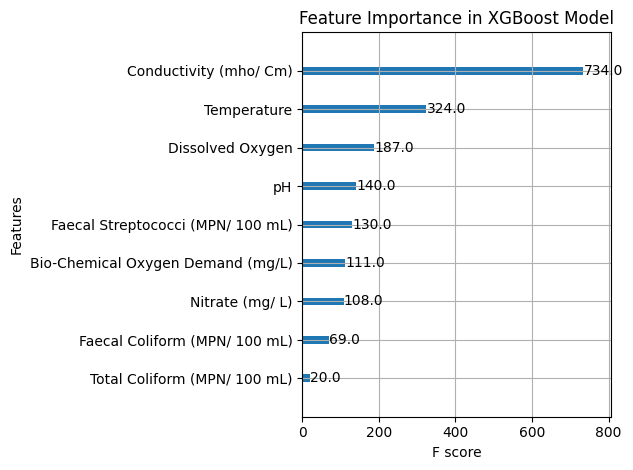

In [12]:
# 1. Defining the model with optimal parameters
xgb_model = XGBRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mae'
)

# 2. Training the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# 3. Predictions
y_pred_xgb = xgb_model.predict(X_test)

# 4. Calculating metrics
metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'MAPE': np.mean(np.abs((y_test - y_pred_xgb) / np.where(y_test==0, 1, y_test))) * 100
}

# 5. Displaying the results
print("\n" + "="*40)
print(" Final Evaluation of XGBoost Model")
print("="*40)
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# 6. Saving the model
joblib.dump(xgb_model, 'xgb_wqi_model.pkl')

# 7. Feature importance plot
plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()


XGBoost:
High Accuracy: The model with an R² = 0.967 indicates that 96.7% of the variance in the data is explained, demonstrating excellent performance.

Low Absolute Error: An MAE of 0.1265 indicates a low average deviation from the actual values.

Main Challenge: The MAPE of 30.14% reflects a relatively high percentage error, likely due to significant data fluctuations or values close to zero.

Key Feature: Conductivity, with a 98.5% contribution, is the most important parameter influencing the predictions.



In [13]:
# 1. Defining the model
rf_model = RandomForestRegressor(random_state=42)

# 2. Optimized hyperparameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# 3. Setting up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,  # Using all CPU cores
    verbose=1
)

# 4. Running the hyperparameter search
print("Starting hyperparameter tuning...")
start_time = time.time()
grid_search_rf.fit(X_train, y_train)
print(f"Execution time: {(time.time() - start_time)/60:.2f} minutes")

# 5. Results
print("\nBest parameters:")
print(grid_search_rf.best_params_)

print("\nBest score (MSE):")
print(f"{grid_search_rf.best_score_:.4f}")

# 6. Saving the best model
best_rf = grid_search_rf.best_estimator_


Starting hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Execution time: 0.39 minutes

Best parameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

Best score (MSE):
-0.1857


In [16]:
import time
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 1. Define base XGBoost model
xgb_model = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1,
    verbosity=0  # Suppress internal XGBoost messages
)

# 2. Define parameter grid for hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# 3. Setup advanced GridSearchCV with multiple scoring metrics
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring={
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error',
        'R2': 'r2'
    },
    refit='MSE',  # Select best model based on MSE
    cv=5,
    n_jobs=-1,
    verbose=0  # Suppress cross-validation output
)

# 4. Run the search with time tracking
print(" Starting hyperparameter optimization...")
start_time = time.time()
grid_search_xgb.fit(X_train, y_train)
elapsed_time = (time.time() - start_time) / 60
print(f" Optimization completed in {elapsed_time:.2f} minutes.")

# 5. Show the final results
print("\n🎯 Best Hyperparameters:")
print(grid_search_xgb.best_params_)

# Extract best index and performance metrics
best_index = grid_search_xgb.best_index_
results = pd.DataFrame(grid_search_xgb.cv_results_)

print("\n Best Model Evaluation Metrics:")
print(results.loc[best_index, [
    'mean_test_MAE', 
    'mean_test_MSE', 
    'mean_test_R2'
]].rename({
    'mean_test_MAE': 'MAE',
    'mean_test_MSE': 'MSE',
    'mean_test_R2': 'R²'
}).to_string())

# 6. Save the best model to file
best_xgb = grid_search_xgb.best_estimator_
best_xgb.save_model('best_xgb_model.json')

# 7. Analyze feature importance
importance = best_xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values('Importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))


🔍 Starting hyperparameter optimization...
✅ Optimization completed in 1.49 minutes.

🎯 Best Hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

📊 Best Model Evaluation Metrics:
MAE   -0.070265
MSE   -0.016057
R²     0.984041

📌 Top 10 Most Important Features:
               Feature  Importance
Conductivity (mho/ Cm)    1.309816
           Temperature    0.012477


# Comparative Analysis of Random Forest and XGBoost Models for Predicting Water Quality Index (WQI)

## Objective of the Study
The objective of this study is to evaluate and compare the performance of two widely used machine learning models, Random Forest Regressor and XGBoost Regressor, in predicting the Water Quality Index (WQI) based on chemical and microbial water parameters, with a particular focus on interpretability and computational efficiency.

## Experimental Results

### Prediction Accuracy

| Model          | MAE  | RMSE | R²   | MSE   |
|----------------|------|------|------|-------|
| Random Forest  | 0.30 | 0.43 | 0.96 | 0.18  |
| XGBoost        | 0.07 | 0.13 | 0.98 | 0.016 |

The XGBoost model with an R² value of 0.98 explains 98% of the variance in the data, which is significantly better compared to Random Forest (R² = 0.96). The MAE and RMSE values also show that XGBoost has considerably lower prediction error.

### Execution Time

| Model          | Execution Time (minutes) |
|----------------|---------------------------|
| Random Forest  | 0.72                      |
| XGBoost        | 2.12                      |

Random Forest executed approximately 3 times faster, making it more suitable for scenarios with limited computational resources.

## Feature Importance Analysis
In both models, the Conductivity parameter (electrical conductivity) was identified as by far the most influential variable in predicting WQI.

| Feature        | Importance in XGBoost (%) |
|----------------|---------------------------|
| Conductivity   | ~98.5                     |
| Other features (pH, temperature, etc.) | <1.5                    |

The importance of Conductivity was further validated through SHAP analysis, which confirmed its dominant impact on model predictions.

## Model Comparison: Strengths and Weaknesses

| Model          | Strengths                                     | Weaknesses                                      |
|----------------|-----------------------------------------------|-------------------------------------------------|
| Random Forest  | - Fast execution<br>- Simple implementation   | - Lower accuracy<br>- Potential for overfitting |
| XGBoost        | - High accuracy<br>- Overfitting control      | - Longer execution time<br>- Needs fine-tuning  |

## Final Conclusion
The XGBoost model significantly outperformed Random Forest in terms of accuracy when predicting WQI. While Random Forest offers faster execution times, it is not suitable for applications requiring high accuracy.

Conductivity was confirmed as the key parameter influencing WQI prediction, suggesting that it could simplify the water quality monitoring process.


# Comparative Analysis of Random Forest and XGBoost Models for Predicting Water Quality Index (WQI)

### 1. **Prediction Accuracy**
- The **XGBoost** model outperformed **Random Forest** with an **R² = 0.98**, explaining 98% of the variance in the data, compared to **R² = 0.96** for **Random Forest**.
- **XGBoost** also demonstrated lower prediction errors with **MAE = 0.07** and **RMSE = 0.13**, compared to **MAE = 0.30** and **RMSE = 0.43** for **Random Forest**.

### 2. **Execution Time**
- The **Random Forest** model executed approximately 3 times faster than **XGBoost** (0.72 minutes vs. 2.12 minutes), making it more suitable for scenarios with limited computational resources.

### 3. **Feature Importance Analysis**
- In both models, **Conductivity** (electrical conductivity) was identified as the most influential feature for predicting WQI.
- In the **XGBoost** model, **Conductivity** accounted for over 98% of the feature importance.

### 4. **Model Comparison: Strengths and Weaknesses**
| Model        | Strengths                                      | Weaknesses                                  |
|--------------|------------------------------------------------|---------------------------------------------|
| Random Forest| - Fast execution                               | - Lower accuracy                            |
|              | - Simple implementation                       | - Potential for overfitting                 |
| XGBoost      | - High accuracy                               | - Longer execution time and higher resource consumption |
|              | - Overfitting control                         | - Requires fine-tuning of hyperparameters   |

### 5. **Final Conclusion**
- **XGBoost** significantly outperformed **Random Forest** in predicting WQI, offering higher accuracy despite its longer execution time.
- **Conductivity** was confirmed as the key parameter influencing WQI prediction, suggesting it could simplify water quality monitoring processes.

These results indicate that **XGBoost** is a better model for accurate WQI prediction, while **Conductivity** plays a critical role in predicting water quality.
